In [81]:
import numpy as np

import pandas as pd

import kagglehub

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, davies_bouldin_score

In [82]:

# Define the dataset path
dataset_path = "/Users/Dataghost/.cache/kagglehub/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/versions/1/Mall_Customers.csv"

# Load the dataset
df = pd.read_csv(dataset_path, encoding="ISO-8859-1")

# Display the first few rows
print(df.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


Step 2: Preprocessing

Remove unnecessary columns (CustomerID, Gender isn't needed for clustering).
Scale the features (StandardScaler ensures all values are on the same scale).

In [83]:
# Select relevant features

features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

In [84]:
# Standardize the data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(features)

Step 2: Determine the Optimal Number of Clusters

use Elbow Method (for K-Means) and AIC/BIC (for GMM).

Finding Optimal Clusters for K-Means (Elbow Method)


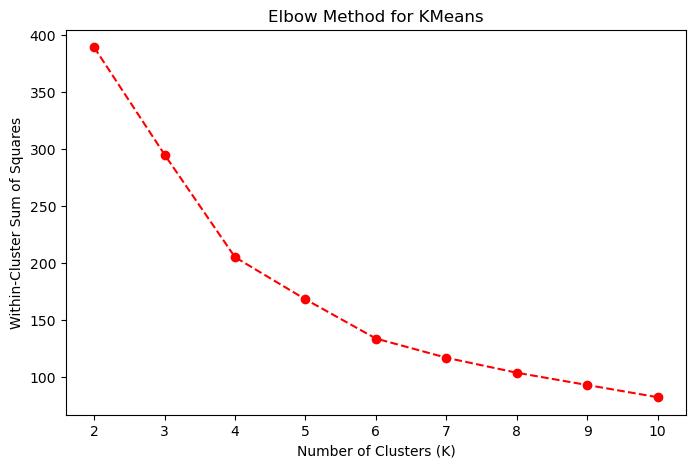

In [85]:
wcss = []  # Within-cluster sum of squares

sil_scores =[]

for i in range(2,11):

    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)

    kmeans.fit(X_scaled)

    wcss.append(kmeans.inertia_)  # Store WCSS

    sil_scores.append(silhouette_score(X_scaled,kmeans.labels_)) # Store Silhouette Score

# Plot the Elbow Curve

plt.figure(figsize=(8,5))

plt.plot(range(2,11),wcss, marker='o', linestyle= '--', color='red')

plt.xlabel('Number of Clusters (K)')

plt.ylabel('Within-Cluster Sum of Squares')

plt.title('Elbow Method for KMeans')

plt.show()


Choose K where WCSS stops decreasing significantly (elbow point).

Finding Optimal Clusters for GMM (AIC & BIC)

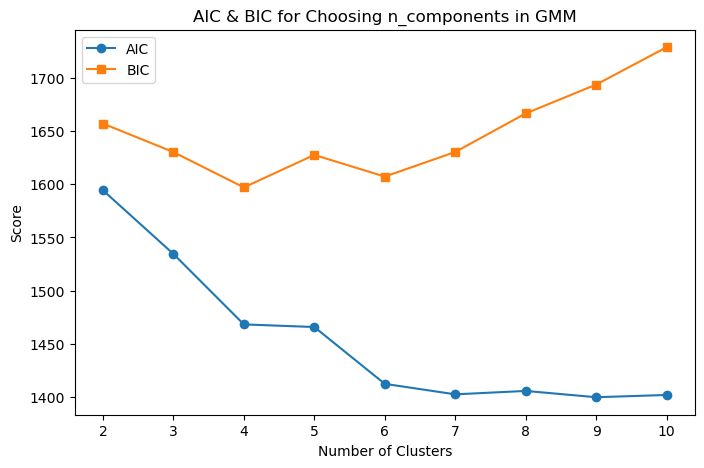

In [86]:
aic_values, bic_values = [],[]

n_components_range= range(2,11)


for n in n_components_range:

    gmm = GaussianMixture(n_components=n, covariance_type='full',random_state=42)

    gmm.fit(X_scaled)

    aic_values.append(gmm.aic(X_scaled))

    bic_values.append(gmm.bic(X_scaled))


# Plot AIC & BIC

plt.figure(figsize=(8,5))

plt.plot(n_components_range,aic_values, label='AIC', marker='o')

plt.plot(n_components_range,bic_values, label='BIC', marker='s')

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.legend()

plt.title('AIC & BIC for Choosing n_components in GMM')

plt.show()

 Select n_components where AIC/BIC stop decreasing significantly.

Step 3: Train Both Models

📌 Train K-Means

In [87]:
# Train K-Means with optimal K (assume best is 4)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

kmeans.fit(X_scaled)

df['Kmeans Cluster'] = kmeans.labels_

In [88]:
# Train GMM with optimal n_components (assume best is 4)

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)

gmm.fit(X_scaled)

df['GMM Cluster'] = gmm.predict(X_scaled)

In [89]:
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Kmeans Cluster,GMM Cluster
0,1,Male,19,15,39,2,0
1,2,Male,21,15,81,2,2
2,3,Female,20,16,6,2,0
3,4,Female,23,16,77,2,2
4,5,Female,31,17,40,2,0


Step 4: Evaluate Clustering Performance

We'll use:

Silhouette Score → Higher is better

Davies-Bouldin Index → Lower is better

In [90]:
# Compute evaluation metrics

kmeans_sil = silhouette_score(X_scaled, df['Kmeans Cluster'])

gmm_sil = silhouette_score(X_scaled, df['GMM Cluster'] )

kmeans_db = davies_bouldin_score(X_scaled, df['Kmeans Cluster'])

gmm_db = davies_bouldin_score(X_scaled, df['GMM Cluster'] )


print(f"K-Means Silhouette Score: {kmeans_sil:.3f}")
print(f"GMM Silhouette Score: {gmm_sil:.3f}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db:.3f}")
print(f"GMM Davies-Bouldin Index: {gmm_db:.3f}")

K-Means Silhouette Score: 0.404
GMM Silhouette Score: 0.373
K-Means Davies-Bouldin Index: 0.931
GMM Davies-Bouldin Index: 0.995


Compare the scores:

Higher Silhouette Score → Better clustering quality

Lower Davies-Bouldin Index → Better separation between clusters

Step 5: Visualizing Clusters

📌 K-Means Clusters (PCA)

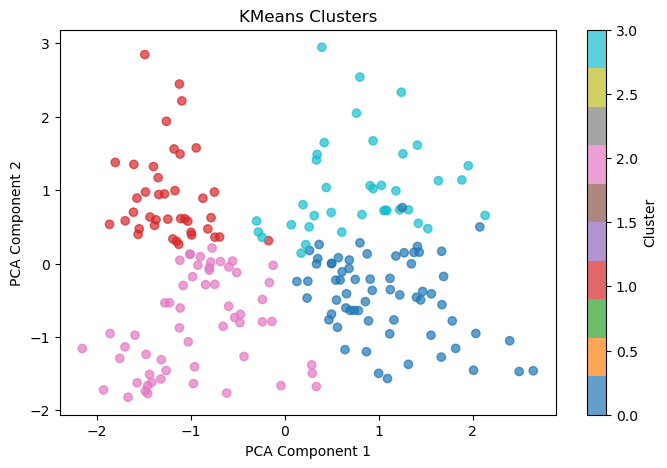

In [91]:
# Reduce dimensions with PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)


# Scatter plot

plt.figure(figsize=(8,5))

plt.scatter(X_pca[:,0],X_pca[:,1], c=df['Kmeans Cluster'], cmap='tab10',alpha=0.7)

plt.xlabel('PCA Component 1')

plt.ylabel('PCA Component 2')

plt.title('KMeans Clusters')

plt.colorbar(label='Cluster')

plt.show()

 GMM Clusters (PCA)

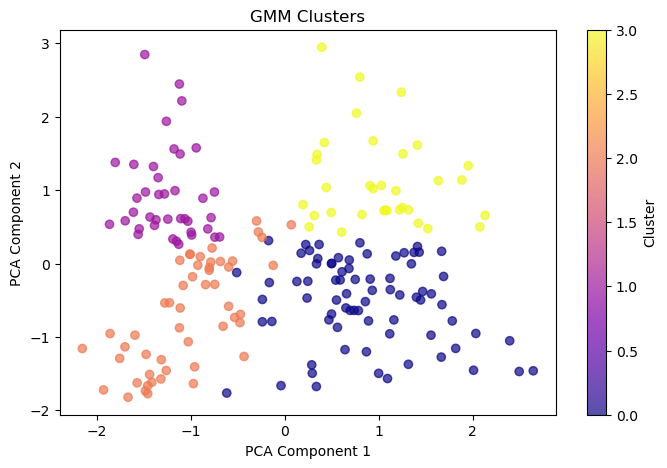

In [92]:
plt.figure(figsize=(8,5))

plt.scatter(X_pca[:,0],X_pca[:,1], c=df['GMM Cluster'], cmap='plasma',alpha=0.7)

plt.xlabel('PCA Component 1')

plt.ylabel('PCA Component 2')

plt.title('GMM Clusters')

plt.colorbar(label='Cluster')

plt.show()

✅ Compare K-Means vs GMM cluster separations.

✅ GMM should show more natural, elliptical clusters while K-Means forces spherical clusters.

Step 6: Analyze the Cluster Characteristics

In [93]:
# Compare cluster means for K-Means

print('K-Means Cluster Summary:')

print(df.groupby('Kmeans Cluster') [["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean())

K-Means Cluster Summary:
                      Age  Annual Income (k$)  Spending Score (1-100)
Kmeans Cluster                                                       
0               53.984615           47.707692               39.969231
1               32.875000           86.100000               81.525000
2               25.438596           40.000000               60.298246
3               39.368421           86.500000               19.578947


In [94]:
# Compare cluster means for GMM

print('GMM Cluster Summary:')

print(df.groupby('GMM Cluster') [["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean())

GMM Cluster Summary:
                   Age  Annual Income (k$)  Spending Score (1-100)
GMM Cluster                                                       
0            50.184211           45.842105               40.697368
1            32.692308           86.538462               82.128205
2            24.333333           43.901961               61.745098
3            42.352941           88.647059               17.500000


 Key Observations:


If Silhouette Score is higher in GMM, it means clusters are well-separated.

If Davies-Bouldin Index is lower in GMM, it means clusters are better defined.

If clusters in K-Means look artificial (spherical), then GMM is likely better.